---
title: A Study on Support Vector Machines
bibliography: references.bib
csl: apa.csl
date: '2025-10-09T09:52:05+11:00'
draft: false
toc: true
jupyter: python3
image: index.png
author:
  - name: Keao Chen, 25584234
format:
  titlepage-pdf:
    fontsize: 12pt
    colorlinks: true
    link-citations: true
    include-in-header:
      text: |
        \usepackage{fvextra}
        \DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaklines,commandchars=\\\{\}}
        \DefineVerbatimEnvironment{OutputCode}{Verbatim}{breaklines,commandchars=\\\{\}}
        \usepackage{luatexja-fontspec}
        \setmainjfont{Noto Serif CJK SC}
    documentclass: scrbook
    classoption:
      - oneside
      - open=any
    number-sections: true
    toc: true
    lof: true
    lot: false
    titlepage: academic
    titlepage-logo: img/logo.png
    second-logo: img/svm.png
    geometry: top=2.5cm, bottom=2.5cm, left=2.5cm, right=2.5cm
    titlepage-theme:
      elements:
        - \headerblock
        - \logoblock
        - \titleblock
        - \authorblock
        - \secondlogoblock
        - \vfill
        - \dateblock
      page-align: center
      title-style: doublelinetight
      title-fontstyle:
        - Huge
        - bfseries
      title-space-after: 1.5cm
      subtitle-fontstyle: Large
      author-style: plain
      logo-size: 0.65\textwidth
      author-space-after: 2.5cm
      affiliation-style: none
      author-fontstyle:
        - Large
        - bfseries
      affiliation-fontstyle: large
      logo-space-after: 2\baselineskip
      header-fontstyle:
        - textsc
        - LARGE
      header-space-after: 1.5cm
      date-fontstyle: large
---


In [1]:
#| echo: false
import numpy as np
import matplotlib.pyplot as plt

plt.rc("image", cmap="Greys")

In [2]:
#| echo: false
def show_images(images, titles=None):
    n = len(images)
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap="gray")
        if titles:
            plt.title(titles[i])
        plt.axis("off")
    plt.show()


def show_hyperplane(f, xlim=(-2, 6), ax=None, figsize=(3, 3)):
    if ax is None:
        ax = plt.gca()
    min, max = xlim
    xvals = np.linspace(min, max, 100)
    xx, yy = np.meshgrid(xvals, xvals)
    Z = f(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contour(
        xx,
        yy,
        Z,
        levels=[-1, 0, 1],
        colors=["gray", "black", "gray"],
        linestyles=["--", "-", "--"],
        linewidths=[1, 2, 1],
    )
    ax.set_xlim(min, max)
    ax.set_ylim(min, max)
    ax.set_aspect("equal")

In [3]:
#| echo: false
np.random.seed(42)

d1 = np.random.randn(18, 2)
d2 = np.random.randn(18, 2) + 4

X_dummy = np.vstack((d1, d2))
y_dummy = np.array([1] * 18 + [-1] * 18)

idx = np.random.permutation(len(X_dummy))
X_dummy = X_dummy[idx]
y_dummy = y_dummy[idx]

X_with_noise = np.append(X_dummy, [[2, 3], [3, 0]], axis=0)
y_with_noise = np.append(y_dummy, [1, -1], axis=0)

# Introduction

Support Vector Machine (SVM), invented by Vladimir Vapnik in 1979, is a kind of machine learning algorithm with solid theoretical foundation [@platt_sequential_1998]. The classical implementation of SVM is to find the optimal separating hyperplane by solving a convex quadratic programming problem. Furthermore, by solving its Lagrangian dual problem, kernel methods can be naturally introduced, enabling SVM to handle not only linear classification problems but also complex non-linear ones. This approach primarily uses optimization theory as a tool and can theoretically find an exact analytical solution using Quadratic Programming (QP) solvers. In practice, however, numerical approaches like Sequential Minimal Optimization (SMO) is often employed instead of general QP solvers for better efficiency.

In addition to this perspective, SVM can also be understood from the general machine learning perspective, that is, optimizing a loss function to fit the data. This method typically employs stochastic gradient descent as a tool, gradually approaching the minimum of the loss function by calculating its gradient. The advantage of this method is its simplicity in implementation and lower computational cost, but it usually can only find an approximate solution and cannot utilize kernel methods. The essence of these two methods is the same, just using different viewpoints.

This report will first introduce the linear classification problem and the perceptron algorithm, which is background knowledge and motivation for SVM. Then, the hard margin maximum margin classifier will be introduced in detail, including its primal and lagrange dual form, and an implementation using a QP solver will be provided. The soft margin maximum margin classifier will be presented as an extension to handle noisy and non-linearly separable data. Two implementations of the soft margin classifier will be provided: one using SMO and the other using stochastic gradient descent. These implementations will be compared on both artificial and real-world datasets. Finally, multi-class classification will be discussed, along with a reflection and conclusion of the report.

## Links

- [GitHub Repository](https://github.com/chenkeao/A-Study-On-SVMs)
- [Colab Notebook](https://colab.research.google.com/drive/1OjK9RxJK0tJ5NS8ND3SRkLxcXDtOuQCi?usp=sharing)
- This report is written with the help of AI. Here is the [first conversation](https://chatgpt.com/share/68e5ef22-459c-8000-b1cb-820eedb221cb) and the [second conversation](https://chatgpt.com/share/68e5f170-603c-8000-9bc4-a915d61c59e1).

# Background

## Linear Classification

SVM is a solution to the linear classification problem. Linear classification refers to the task of classifying data points into different categories based on a linear decision boundary. If the input space $X$ is a subset of $\mathbb{R}^n$, where $n\ge1$ is the number of features in the dataset, a linear decision boundary can be defined as a flat affine subspace of dimension $n-1$. For example, in a 2-dimensional space, the decision boundary is a line, while in a 3-dimensional space, it is a plane. In higher-dimensional spaces, it is referred to as a hyperplane.

A hyperplane can be defined by the equation:

$$
\mathbf{w} \cdot \mathbf{x} + b = 0
$$

If a point $\mathbf{x}_0$ does not lie on the hyperplane, it must either satisfy

$$
\mathbf{w} \cdot \mathbf{x}_0 + b > 0
$$

or

$$
\mathbf{w} \cdot \mathbf{x}_0 + b < 0
$$

The side that the point lies on can be determined by its sign:

$$
sign(\mathbf{w} \cdot \mathbf{x}_0 + b)
$$

The learning task of linear classification is to find a hyperplane that separates the data points into two classes correctly, providing the dataset is linearly separable. Therefore, the hypothesis set $H$ for linear classification can be defined as the set of all possible hyperplanes in the input space $X$.

## Perceptron

Perhaps the simplest algorithm for finding a hyperplane is the Perceptron Learning Algorithm (PLA). The PLA iteratively updates the parameters $\mathbf{w}$ and $b$ of the hyperplane based on the misclassified data points. It has been proven that as long as the data is linearly separable, the perceptron algorithm is guaranteed to converge.

Let the class label be denoted by $y$, where $y = 1$ for the positive class and $y = -1$ for the negative class. The product

$$
y (\mathbf{w} \cdot \mathbf{x} + b)
$$

indicates the correctness of the prediction: a positive value implies a correct prediction, while a negative value indicates a misclassification.

Perceptron learns from misclassifications. When a data point is correctly classified, the algorithm proceeds to the next data point without updating the model, whereas when a data point is misclassified, the model parameters are updated according to the following rules:

$$
\begin{aligned}
&\mathbf{w} \leftarrow \mathbf{w} + lr \cdot y \cdot \mathbf{x} \nonumber \\
&b \leftarrow b + lr \cdot y \nonumber
\end{aligned}
$$

where $lr$ is the learning rate that pre-defined as a hyperparameter.

This update mechanism implies that if the true label is positive and the data point is misclassified, the normal vector $\mathbf{w}$ of the hyperplane is adjusted in the direction of $\mathbf{x}$, thereby increasing the likelihood of correctly classifying $\mathbf{x}$ as a positive instance. Conversely, if the true label is negative, the vector $\mathbf{w}$ is updated in the opposite direction of $\mathbf{x}$, making it more likely that $\mathbf{x}$ will be classified as negative.

In [4]:
#| echo: false
class MyPerceptron:

    def __init__(self, lr=0.1, epochs=10, history=False):
        self.lr = lr
        self.epochs = epochs
        self.history = history
        self.losses = []
        self.records = []

    def f(self, x):
        return x @ self.w + self.b

    def sign(self, x):
        return np.where(x > 0, 1, -1)

    def predict(self, x):
        return self.sign(self.f(x))

    def record(self, w, b, current_loss, i):
        self.records.append([(w, self.w.copy()), (b, self.b), current_loss, i])

    def fit(self, X, y):
        _, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.epochs):
            for i, (xi, yi) in enumerate(zip(X, y)):
                y_hat = self.predict(xi)

                old_w = self.w.copy()
                old_b = self.b
                if self.history:
                    current_loss = (self.sign(self.f(X)) != y).mean()

                if self.history and current_loss == 0:
                    self.record(old_w, old_b, current_loss, i)
                    return

                if yi * y_hat < 0:
                    self.w += self.lr * yi * xi
                    self.b += self.lr * yi
                    if self.history:
                        self.record(old_w, old_b, current_loss, i)

In [5]:
#| echo: false
def plot_records(X, y, records, show_legend=True, show_previous=True, figsize=(15, 15)):
    n_updates = len(records)

    cols = 3
    rows = int(np.ceil(n_updates / cols))
    _, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.flatten() if n_updates > 1 else [axs]

    x_margin = 2.0
    y_margin = 2.0
    x_min = np.min(X[:, 0]) - x_margin
    x_max = np.max(X[:, 0]) + x_margin
    y_min = np.min(X[:, 1]) - y_margin
    y_max = np.max(X[:, 1]) + y_margin

    for i in range(n_updates):
        ax = axs[i]
        old_w, new_w = records[i][0]
        old_b, new_b = records[i][1]

        pos_idx = y == 1
        neg_idx = y == -1
        ax.scatter(
            X[pos_idx, 0],
            X[pos_idx, 1],
            color="blue",
            alpha=0.6,
            marker="+",
        )
        ax.scatter(
            X[neg_idx, 0],
            X[neg_idx, 1],
            color="red",
            alpha=0.6,
        )

        ax.scatter(
            X[records[i][3], 0],
            X[records[i][3], 1],
            facecolor="yellow",
            edgecolor="black",
            label="Current Point",
        )

        def plot_hp(w, b, color, linestyle, label):
            x_vals = np.linspace(x_min, x_max, 100)
            if abs(w[1]) > 1e-6:
                y_vals = (-w[0] * x_vals - b) / w[1]
                ax.plot(
                    x_vals,
                    y_vals,
                    color=color,
                    linestyle=linestyle,
                    label=label,
                )
            else:
                x_val = -b / w[0] if abs(w[0]) > 1e-6 else 0
                ax.axvline(x_val, color=color, linestyle=linestyle, label=label)
            return x_vals, y_vals if abs(w[1]) > 1e-6 else None

        plot_hp(new_w, new_b, "black", "-", "After Update")

        if show_previous:
            plot_hp(old_w, old_b, "green", "--", "Before Update")
            x0 = 0
            y0 = (-old_w[0] * x0 - old_b) / old_w[1] if old_w[1] != 0 else 0
            norm = np.linalg.norm(old_w)
            if norm != 0:
                ax.arrow(
                    x0,
                    y0,
                    old_w[0] / norm,
                    old_w[1] / norm,
                    head_width=0.5,
                    width=0.1,
                    color="green",
                )
        x0 = 0
        y0 = (-new_w[0] * x0 - new_b) / new_w[1] if new_w[1] != 0 else 0
        norm = np.linalg.norm(new_w)
        if norm != 0:
            ax.arrow(
                x0,
                y0,
                new_w[0] / norm,
                new_w[1] / norm,
                head_width=0.5,
                width=0.1,
                color="black",
            )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_title(f"Update {i+1}")
        ax.set_aspect("equal")
        if show_legend:
            ax.legend()

    for j in range(n_updates, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

The figure below shows the learning process of a perceptron on a synthetic dataset. The green arrow represents the normal vector before the update, while the black arrow shows the normal vector after the update. For example, in Update 6, when a positive sample (the yellow point) lies on negative side of the hyperplane, the green arrow shifts closer to this data point after the update and thereby the updated hyperplane classifies this point correctly.

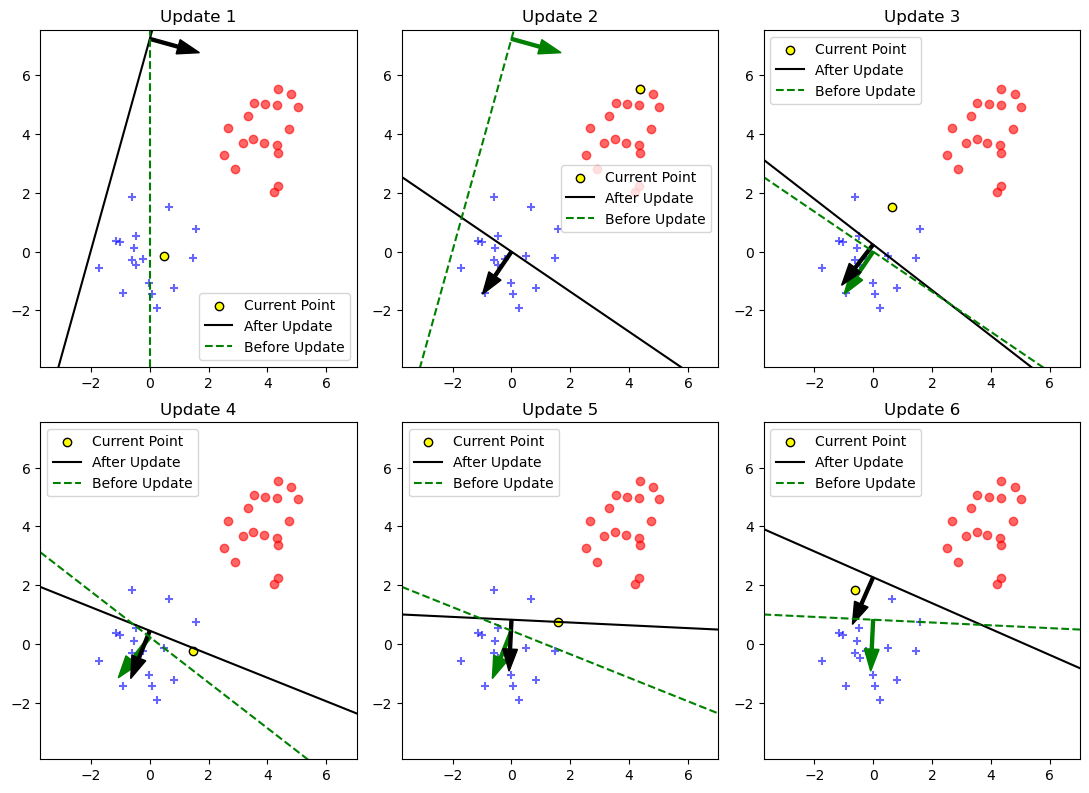

In [6]:
#| fig-cap: Perceptron Learning Process
#| echo: false
perceptron = MyPerceptron(lr=0.1, epochs=2, history=True)
perceptron.fit(X_dummy, y_dummy)
plot_records(X_dummy, y_dummy, perceptron.records[:-1], figsize=(11, 8))

It is clear that after six updates the hyperplane that the perceptron found has separated all data points correctly, but is it the best one? Actually, it is almost the worst, since it is very close to one side. Intuitively, the optimal hyperplane should look like the one below, which maximizes the distance to the nearest data points from both classes. Therefore, the model has a bigger cushion to tolerate noise and outliers. This is the main idea and motivation of SVMs.

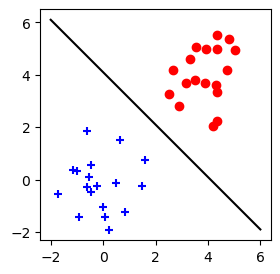

In [7]:
#| fig-cap: The Optimal Hyperplane
#| echo: false
plt.figure(figsize=(3, 3))
plt.scatter(d1[0:, 0], d1[0:, 1], color="blue", marker="+")
plt.scatter(d2[0:, 0], d2[0:, 1], color="red", marker="o")
plt.plot(
    np.linspace(-2, 6, 10),
    -np.linspace(-2, 6, 10) + 4.1,
    color="black",
)
plt.gca().set_aspect("equal")
plt.show()

Furthermore, the hyperplane found by the perceptron is not unique. Different initializations of the model parameters or variations in the order of data presentation can lead to different hyperplanes [@bishop_pattern_2006]. The following figure illustrates six different hyperplanes obtained by perceptron with different shuffles of the training data. Obviously, they vary significantly.

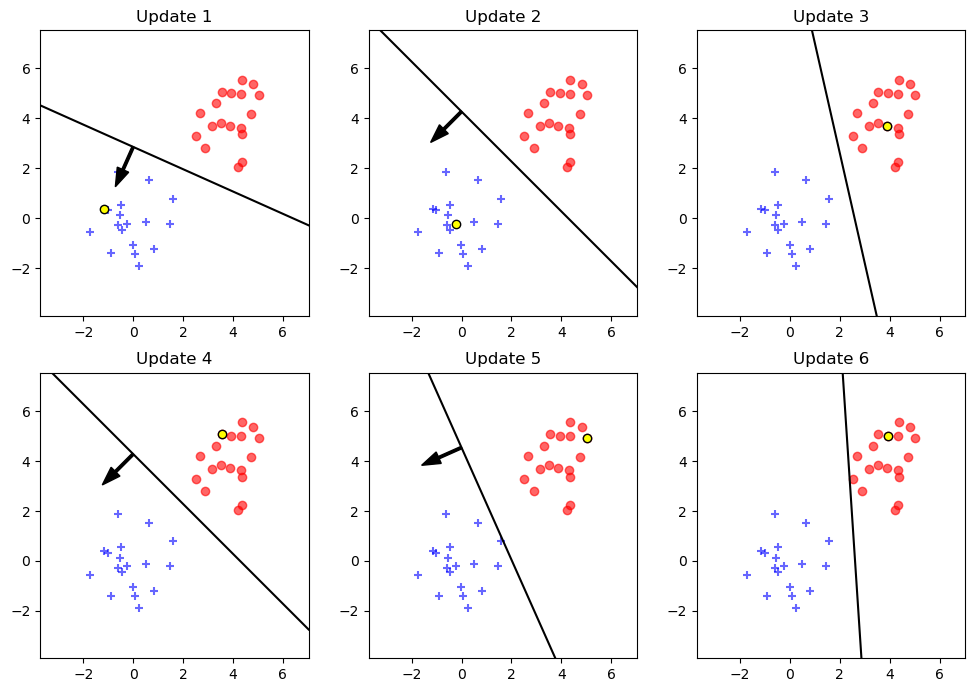

In [8]:
#| fig-cap: Different Final Hyperplane With Different Data Order
#| echo: false
params = []
for i in range(6):
    idx = np.random.permutation(len(X_dummy))
    X_shuffled = X_dummy[idx]
    y_shuffled = y_dummy[idx]
    perceptron = MyPerceptron(lr=1, epochs=5, history=True)
    perceptron.fit(X_shuffled, y_shuffled)
    params.append(perceptron.records[-1])
plot_records(
    X_shuffled,
    y_shuffled,
    params,
    show_legend=False,
    show_previous=False,
    figsize=(10, 7),
)

# Linear Support Vector Machines

## Maximum Margin Classifier With Hard Margin

Maximum Margin Classifier is a solution to the problems of perceptron mentioned above. Unlike Perceptron, Maximum Margin Classifier is able to find the optimal decision boundary by maximizing its margin. Margin is defined to be the smallest distance between the decision boundary and any of the samples [@bishop_pattern_2006].

### Functional Distance and Geometric Distance

The distance from a point $\mathbf{x}_0$ to a hyperplane $h$ can be calculated by substituting $\mathbf{x}$ into the equation of the hyperplane:

$$
distance(x_0,h)=|\mathbf{w}\cdot\mathbf{x}_0 + b|
$$

if the hyperplane correctly classifies the point, the distance can also be expressed as:

$$
distance(x_0,h)=y_0(\mathbf{w}\cdot\mathbf{x}_0 + b)
$$

where $y_0$ is the class label of $\mathbf{x}_0$. This is called the functional distance.

In addition, this value can by manipulated arbitrarily. For example,

$$
\mathbf{w}\cdot\mathbf{x} + b = 0 \quad \text{and} \quad 2\mathbf{w}\cdot\mathbf{x} + 2b = 0
$$

represent the same hyperplane, but for the same input $x$, they yield different values. In fact, the latter is exactly twice the former. Therefore, we can pick a particular scalar to rescale the hyperplane, making it yield preferred output. We choose the scalar to be $1/\rho$, where

$$
\rho = \min\limits_{i=1,\cdots,n}{y_i(\mathbf{w}\cdot\mathbf{x}_i+b)}
$$

so that:

$$
\min\limits_{i=1,\cdots,n}{y_i(\frac{\mathbf{w}}{\rho}\cdot\mathbf{x}_i+\frac{b}{\rho})}=\frac{1}{\rho}\min\limits_{i=1,\cdots,n}{y_i(\mathbf{w}\cdot\mathbf{x}_i+b)=\frac{\rho}{\rho}=1}
$$

Therefore, for any hyperplane, we can always rescale it to make the functional distance of the closest data points equal to 1.

Furthermore, the geometric distance from a point $\mathbf{x}_0$ to the hyperplane $h_0$ can be calculated as:

$$
\frac{y_0(\mathbf{w} \cdot \mathbf{x}_0 + b)}{\|\mathbf{w}\|}
$$

In other words, it is the functional distance divided by the norm of the normal vector $\mathbf{w}$. Geometric distance is also called Euclidean distance, which is invariant to the rescaling of the hyperplane.

The margin of a hyperplane is defined as the geometric distance from the hyperplane to the closest data points. The optimal hyperplane is the one that maximizes the margin. Since the hyperplane is determined by $\mathbf{w}$ and $b$, the optimization problem can be formulated as follows:

$$
\arg\max\limits_{\mathbf{w},b}{\left\{\frac{1}{\|\mathbf{w}\|}\min\limits_{i=1,\cdots,n}{\left[y_i(\mathbf{w} \cdot \mathbf{x}_i + b)\right]}\right\}}
$$

Since we can always rescale the hyperplane so that 

$$
\min\limits_{i=1,\cdots,n}y_i(\mathbf{w} \cdot \mathbf{x}_i + b)=1
$$

Thus, the optimization problem can be rewritten in a simpler form:

$$
\begin{aligned}
\arg\min\limits_{\mathbf{w},b}\quad& \frac{1}{2}||\mathbf{w}||^2  \nonumber \\
s.t. \quad &1-y_i(\mathbf{w}\cdot\mathbf{x}_i+b)\le0, i=1, \cdots, n \nonumber
\end{aligned}
$$

Here, the coefficient $\frac{1}{2}$ is introduced to simplify the result after differentiation.

### Primal Problem

The lagrange function of this optimization problem is:

$$
L(\mathbf{w}, b, \alpha)=\frac{1}{2}||\mathbf{w}||^2+\sum_{i=1}^{n}{\alpha_i\left[1-y_i (\mathbf{w} \cdot \mathbf{x}_i + b)\right]}
$$

where $\alpha_i\ge0$ are the lagrange multipliers.

If we maximize $L$ w.r.t. $\alpha$:

$$
\begin{aligned}
\theta(\mathbf{w}, b)
&= \max_{\alpha \ge 0} L(\mathbf{w}, b, \alpha) \\
&= \max_{\alpha \ge 0} \frac{1}{2}\|\mathbf{w}\|^2 + \sum_{i=1}^{n} \alpha_i \bigl[1 - y_i (\mathbf{w} \cdot \mathbf{x}_i + b)\bigr] \nonumber
\end{aligned}
$$

It turns out that if there is an $\mathbf{x}_i$ that satisfies

$$
1-y_i (\mathbf{w} \cdot \mathbf{x}_i + b) > 0
$$

which violates the constraint, $L$ will go to $+\infty$, by making $\alpha = +\infty$, whereas if all $\mathbf{x}_i$ satisfy the constraint, the maximum value of $L$ would be $\frac{1}{2}||\mathbf{w}||^2$ because we have to make all $\alpha_i=0$ to avoid negative value.

Therefore, $\theta(\mathbf{w}, b)$ is actually defined by:

$$
\theta(\mathbf{w}, b) = \left\{
  \begin{array}{lr}
    \frac{1}{2}||\mathbf{w}||^2 & \text{if constraints are satisfied} \\
    +\infty & \text{otherwise}
  \end{array}
\right.
$$

Minimize function $\theta(\mathbf{w}, b)$ w.r.t. $\mathbf{w}$ and $b$:

$$
\min\limits_{\mathbf{w}, b}{\theta(\mathbf{w}, b)}=\min\limits_{\mathbf{w}, b}{\max\limits_{\alpha:\alpha_i\ge0}{L(\mathbf{w}, b, \alpha)}}
$$

is equivalent to the original optimization problem and it's called the primal problem.

### Dual Problem

If we instead minimize $L$ w.r.t. $\mathbf{w}$ and $b$ first and then maximize it w.r.t. $\alpha$, it yields the dual problem:

$$
\max\limits_{\alpha:\alpha_i\ge0}{\min\limits_{\mathbf{w}, b}{L(\mathbf{w}, b, \alpha)}}
$$

There are several advantages of solving the dual problem instead of the primal one. First, the dual problem is always a convex optimization problem by nature (this is because the target function is linear w.r.t. $\alpha$ and the constraint sets are always convex sets), whereas the primal problem may not be convex, though in this case it is. Nevertheless, it's still a good practice to solve the dual problem, because it is usually simpler to solve than the primal one. It has been proven that for SVMs, solving the dual problem is equivalent to solving the primal one.

To solve the dual problem, first set the derivatives of $L$ w.r.t. $\mathbf{w}$ and $b$ to zero:

$$
\begin{aligned}
\nabla_\mathbf{w}L(\mathbf{w}, b, \alpha)&=\mathbf{w}-\sum_{i=1}^{n}{\alpha_i y_i \mathbf{x}_i}=0 \\
\nabla_{b}L(\mathbf{w}, b, \alpha)&=-\sum_{i=1}^{n}{\alpha_i y_i}=0
\end{aligned}
$$

we obtain:

$$
\begin{aligned}
&\mathbf{w}=\sum_{i=1}^{n}{\alpha_i y_i \mathbf{x}_i}\\
&\sum_{i=1}^{n}{\alpha_i y_i}=0
\end{aligned}
$$ {#eq-w-b}

substituting them back into $L$:

$$
\min\limits_{\mathbf{w},b}L(\mathbf{w}, b, \alpha)=
-\frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n{\alpha_i \alpha_j y_i y_j (\mathbf{x}_i \cdot \mathbf{x}_j)} + \sum_{i=1}^n{\alpha_i}
$$

Having done that, maximizing w.r.t. $\alpha$, dual optimization problem can then be summarized as:

$$
\begin{aligned}
\max\limits_{\alpha} \quad & \sum_{i=1}^n{\alpha_i} - \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n{\alpha_i \alpha_j y_i y_j (\mathbf{x}_i \cdot \mathbf{x}_j)} \nonumber \\
s.t.\quad &\alpha_i\ge0, i=1,\cdots,n \nonumber \\
&\sum_{i=1}^{n}{\alpha_i y_i}=0 \nonumber
\end{aligned}
$$ {#eq-dual}

### Solving the Dual Problem Using a QP Solver

@eq-dual is a simpler quadratic programming problem, which can be solved by standard optimization tools. In this case, cvxopt is used and the standard form of a quadratic programming problem that cvxopt uses is:

$$
\begin{aligned}
\min\limits_{x}\quad& \frac{1}{2}x^\top P x + q^\top x \nonumber \\
s.t. \quad &G x \le h, Ax = b \nonumber
\end{aligned}
$$

To write the dual problem in that form, note that

$$
\sum_{i,j}{\alpha_i \alpha_j y_i y_j (\mathbf{x}_i \cdot \mathbf{x}_j)}
$$

can be expressed as a quadratic form: $\alpha^\top P \alpha$, where

$$
P_{ij}=y_i y_j (\mathbf{x}_i \cdot \mathbf{x}_j)
$$

Let

$$
q=\mathbf{-1}, G=-I, h=\mathbf{0}, A=\mathbf{y}, b=0
$$

where $I$ is the $n\times n$ identity matrix. In this way, the dual problem can be written in the standard quadratic programming form:

$$
\begin{aligned}
\min\limits_{\alpha} \quad & \frac{1}{2} \alpha^\top P \alpha + (\mathbf{-1}^\top \alpha) \nonumber \\
s.t.\quad &-I \alpha \le \mathbf{0} \nonumber \\
&\mathbf{y}^\top \alpha = 0 \nonumber
\end{aligned}
$$

The corresponding Python code is as follows:

```python
P = matrix(np.outer(y, y) * (X @ X.T))
q = matrix(-np.ones(n_samples))
G = matrix(-np.eye(n_samples))
h = matrix(np.zeros(n_samples))
A = matrix(y.reshape(1, -1).astype(float))
b_eq = matrix(0.0)
```

After solving for the optimal solution $\alpha^*$, we can obtain the optimal solution $\mathbf{w}^*$ and $b^*$ of the primal problem according to @eq-w-b and the Karush-Kuhn-Tucker (KKT) conditions, which are necessary and sufficient conditions for optimality [@platt_sequential_1998]:

$$
\begin{aligned}
&\mathbf{w}^*=\sum_{i=1}^{n}{\alpha_i^* y_i \mathbf{x}_i} \\
&b^*=y_j-\sum_{i=1}^{n}{\alpha_i^* y_i (\mathbf{x}_i \cdot \mathbf{x}_j)}
\end{aligned}
$$

where $\mathbf{x}_j$ is any of the support vectors that satisfy $\alpha^*_j>0$. Here, according to complementary slackness in KKT, $\alpha_j^*>0$ indicates that $\mathbf{x}_j$ is a support vector, which lies on the margin boundary and satisfies:

$$
y_i(\mathbf{w}^*\cdot \mathbf{x}_i+b^*)=1
$$

The other data points with $\alpha_i^*=0$ do not contribute to the decision function, which reveals that the hyperplane depends only on the support vectors.

A better approach to compute $b$ is to use all support vectors, as this makes it numerically more stable [@bishop_pattern_2006]:

$$
b = \frac{1}{N}\sum_{i\in S}\left(y_i-\sum_{j \in S}^{n}{\alpha_j^* y_j (\mathbf{x}_i \cdot \mathbf{x}_j)}\right)
$$

where $S$ is the set of indexes of all support vectors and $N$ is the number of support vectors. 

The Python code for computing $\mathbf{w}$ and $b$ based on $\alpha$ is as follows:

```python
w = np.sum((alphas * labels).reshape(-1, 1) * support_vectors,axis=0)
b = labels[0] - (support_vectors[0] @ w) # use one support vector
b = np.mean([y_i - np.sum(alphas * labels * (X @ x_i)) for i, x_i, y_i in zip(sv_indices, support_vectors, support_vector_labels)]) # use all support vectors

def predict(self, X):
    return np.sign(X @ w + b)
```

The decision function of the maximum margin classifier is:

$$
f(\mathbf{x})=\mathbf{w}^*\cdot\mathbf{x}+b^*=\sum_{i=1}^{n}{\alpha_i^* y_i (\mathbf{x}_i \cdot \mathbf{x})}+b^*
$$

or equivalently:

$$
f(\mathbf{x})=\sum_{i \in S}{\alpha_i^* y_i (\mathbf{x}_i \cdot \mathbf{x})}+b^*
$$

This is because only support vectors have non-zero $\alpha_i^*$.

In [9]:
#| echo: false
import cvxopt
from cvxopt import matrix, solvers


class HardMarginSVM:
    def __init__(self):
        self.w = None
        self.b = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.alphas = None

    def fit(self, X, y):
        n_samples, _ = X.shape

        P = matrix(np.outer(y, y) * (X @ X.T))

        q = matrix(-np.ones(n_samples))

        G = matrix(-np.eye(n_samples))
        h = matrix(np.zeros(n_samples))

        A = matrix(y.reshape(1, -1).astype(float))
        b_eq = matrix(0.0)

        # Solve the quadratic programming problem
        solvers.options["show_progress"] = False
        solution = solvers.qp(P, q, G, h, A, b_eq)

        # Extract alphas
        alphas = np.array(solution["x"]).flatten()

        # Find support vectors (alphas > threshold)
        sv_threshold = 1e-5
        sv_indices = alphas > sv_threshold

        self.support_vectors = X[sv_indices]
        self.support_vector_labels = y[sv_indices]
        self.alphas = alphas[sv_indices]

        # Calculate w
        self.w = np.sum(
            (self.alphas * self.support_vector_labels).reshape(-1, 1)
            * self.support_vectors,
            axis=0,
        )

        # Calculate b using any support vector
        self.b = self.support_vector_labels[0] - np.dot(self.support_vectors[0], self.w)

        return self

    def predict(self, X):
        return np.sign(self.decision_function(X))

    def decision_function(self, X):
        return X @ self.w + self.b

The figure below shows the decision boundary found by the maximum margin classifier on the same synthetic dataset as perceptron used. It is clear that the hyperplane maximizes the margin and classifies all data points correctly.

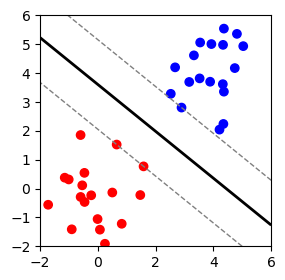

In [10]:
#| echo: false
#| fig-cap: The Classification Boundary Found by MMC
qp_svm = HardMarginSVM()
qp_svm.fit(X_dummy, y_dummy)
plt.figure(figsize=(3, 3))
plt.scatter(X_dummy[:, 0], X_dummy[:, 1], c=y_dummy, cmap="bwr", alpha=1)
show_hyperplane(qp_svm.decision_function, (-2, 6))

## Maximum Margin Classifier With Soft Margin

Even though a maximum margin classifier is able to find the optimal hyperplane for linearly separable data already, it is quite sensitive to noise and outliers. In addition, real-world data is often not linearly separable, in which case the maximum margin classifier fails to find a decision boundary.

A solution to these problems is to introduce slack variables $\xi = \{\xi_1, \cdots, \xi_n\}$ for each data point that allow some points to violate the margin or even the decision boundary. In this way, the model gives up classifying all training data correctly, but it allows some data points, which are probably noises or outliers, to be very close to the decision boundary or even on the wrong side of it.

This will increase the bias of the model but reduce its variance, leading to a worse performance on training set, but probably a better performance on testing data. In other words, it generalizes better. Moreover, to trade off the margin size and the number of misclassifications, a regularization parameter $C$ is introduced. Accordingly, the optimization problem becomes:

$$
\begin{aligned}
\min\limits_{\mathbf{w}, b, \xi} \quad & \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^{n}{\xi_i} \nonumber \\
s.t. \quad & y_i(\mathbf{w}\cdot\mathbf{x}_i+b)\ge1-\xi_i, i=1,\cdots,n \nonumber \\
&\xi_i\ge0, i=1,\cdots,n \nonumber
\end{aligned}
$$

and its dual problem becomes:

$$
\begin{aligned}
\max\limits_{\alpha} \quad & \sum_{i=1}^n{\alpha_i} - \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n{\alpha_i \alpha_j y_i y_j (\mathbf{x}_i \cdot \mathbf{x}_j)} \nonumber \\
s.t.\quad &0\le \alpha_i\le C, i=1,\cdots,n \nonumber \\
&\sum_{i=1}^{n}{\alpha_i y_i}=0 \nonumber
\end{aligned}
$$

It turns out that the only difference from the hard margin SVM is that $\alpha_i$ now has an upper bound $C$. In addition, the support vectors can be categorized into two types: the first type are those that lie exactly on the margin boundary, which satisfy $0 < \alpha_i < C$; the second type are those that violate the margin or even the decision boundary, which satisfy $\alpha_i = C$. The other data points with $\alpha_i = 0$ still do not contribute to the decision function.

### Sequential Minimal Optimization

Sequential Minimal Optimization (SMO) is a popular algorithm for solving the dual problem of the soft margin SVM. The main idea behind SMO is coordinate descent optimized specifically for the SVM dual problem. Coordinate descent refers to optimizing one variable at a time while keeping the others fixed. Therefore, for convex optimization problems, the optimization problem is reduced to finding the minimum of a single variable convex function. However, in the case of SVM dual problem, there is an equality constraint:

$$
\sum_{i=1}^{n}{\alpha_i y_i}=0
$$

for which if we optimize one $\alpha_i$ at a time, it is impossible to satisfy the constraint. To address this issue, SMO optimizes two variables at a time, which allows to adjust one variable while compensating with the other to satisfy the equality constraint.

The following conclusions are from @platt_sequential_1998.

#### Two-variable Optimization

According to @eq-w-b, we have:

$$
f(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b = \sum_{i=1}^{n}{\alpha_i y_i (\mathbf{x}_i \cdot \mathbf{x})} + b
$$

Let $E_i = f(\mathbf{x}_i) - y_i$ and $K_{ij} = \mathbf{x}_i \cdot \mathbf{x}_j$.

Assuming we select $\alpha_1$ and $\alpha_2$ to optimize, the unclipped solution is:

$$
\begin{aligned}
&\alpha_2^{new} = \alpha_2 + \frac{y_2 (E_1 - E_2)}{\eta} \\
&\alpha_1^{new} = \alpha_1 + y_1 y_2 (\alpha_2 - \alpha_2^{new})
\end{aligned}
$$

where $\eta = 2K_{12} - K_{11} - K_{22}$.

To ensure that the new $\alpha_1$ and $\alpha_2$ satisfy the constraints, we need to clip them within the feasible region. The clipping bounds depend on whether $y_1$ and $y_2$ are the same or different:

$$
\begin{aligned}
\text{if}&\quad y_1 \neq y_2: \\
&\quad L = \max(0, \alpha_2 - \alpha_1) \\
&\quad H = \min(C, C + \alpha_2 - \alpha_1) \\
\\
\text{if}&\quad y_1 = y_2: \\
&\quad L = \max(0, \alpha_1 + \alpha_2 - C) \\
&\quad H = \min(C, \alpha_1 + \alpha_2)
\end{aligned}
$$

The pseudo Python code below demonstrates the two-variable optimization process. `i1`, `i2` are the indexes of the two variables being optimized. The array `alphas` stores the values of all $\alpha_i$, `y` stores the class labels, and `K` is the kernel matrix (Since I do not introduce kernel trick, it is just inner product). The function `compute_error` computes the error $E_i$, which is the difference between the predicted and true labels.

```python
if i1 == i2: return 0
alpha1, alpha2 = alphas[i1], alphas[i2]
y1, y2 = y[i1], y[i2]
E1, E2 = compute_error(i1), compute_error(i2)
s = y1 * y2
if y1 != y2:
    L = max(0, alpha2 - alpha1)
    H = min(self.C, self.C + alpha2 - alpha1)
else:
    L = max(0, alpha1 + alpha2 - self.C)
    H = min(self.C, alpha1 + alpha2)
if L == H: return 0
k11, k12, k22 = K[i1, i1], K[i1, i2], K[i2, i2]
eta = k11 + k22 - 2 * k12
if eta > 0:
    alpha2_new = alpha2 + y2 * (E1 - E2) / eta
    if alpha2_new >= H: alpha2_new = H
    elif alpha2_new <= L: alpha2_new = L
else:
    alpha2_new = L if abs(alpha2 - L) < abs(alpha2 - H) else H
alpha1_new = alpha1 + s * (alpha2 - alpha2_new)
```

#### Choosing Variables

In fact, as long as SMO always selects two variables to optimize, it will eventually converge [@platt_sequential_1998]. To speed up this process, SMO uses heuristics to choose variables. The selections of the first and the second variable are called the outer and inner loop, respectively. 

According to @platt_sequential_1998, the algorithm for selecting two variables is as follows:

Outer Loop:

1. Iterates over all data points and examines whether they violate the KKT conditions. If a data point violates the KKT conditions, it is eligible for selection.
2. Iterate only over non-bound examples ($0 < \alpha < C$)
3. Repeat step 2 until all of the non-bound examples obey the KKT conditions within a specified tolerance, typically $10^{-3}$.
4. Alternate between "entire training set pass" and "repeated non-bound subset passes" until entire training set satisfies KKT conditions.

Inner Loop:

1. Approximate step size by $|E_1 - E_2|$. If $E_i > 0$, choose example with minimum $E_2$, whereas if $E_1 < 0$: choose example with maximum $E_2$.

If the choice of the second variable makes no positive progress, then iterate through non-bound examples, and find one that makes positive progress; If still no progress, iterate through entire training set. If nothing works, skip this pair and return to the outer loop.

#### Computing $b$

1. If $\alpha_1$ is non-bound: use $b_1$
2. If $\alpha_2$ is non-bound: use $b_2$
3. If both non-bound: use either (they should be equal, or average for numerical stability)
4. If both bound: use $\frac{(b_1 + b_2)}{2}$

In [ ]:
#| echo: false
# | echo: false
class SMOSVM:
    def __init__(self, C=1.0, tol=1e-3, max_iter=100, gamma=1.0):
        self.C = C
        self.tol = tol
        self.max_iter = max_iter

    def _compute_error(self, i):
        return self.f[i] - self.y[i]


    def _take_step(self, i1, i2):
        if i1 == i2:
            return 0

        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self._compute_error(i1)
        E2 = self._compute_error(i2)
        s = y1 * y2

        if y1 != y2:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        else:
            L = max(0, alpha1 + alpha2 - self.C)
            H = min(self.C, alpha1 + alpha2)

        if L == H:
            return 0

        k11 = self.K[i1, i1]
        k12 = self.K[i1, i2]
        k22 = self.K[i2, i2]
        eta = k11 + k22 - 2 * k12

        if eta > 0:
            alpha2_new = alpha2 + y2 * (E1 - E2) / eta

            if alpha2_new >= H:
                alpha2_new = H
            elif alpha2_new <= L:
                alpha2_new = L
        else:
            alpha2_new = L if abs(alpha2 - L) < abs(alpha2 - H) else H

        if abs(alpha2_new - alpha2) < 1e-5:
            return 0

        alpha1_new = alpha1 + s * (alpha2 - alpha2_new)

        b1 = (
            self.b
            - E1
            - y1 * (alpha1_new - alpha1) * k11
            - y2 * (alpha2_new - alpha2) * k12
        )
        b2 = (
            self.b
            - E2
            - y1 * (alpha1_new - alpha1) * k12
            - y2 * (alpha2_new - alpha2) * k22
        )

        if 0 < alpha1_new < self.C:
            b_new = b1
        elif 0 < alpha2_new < self.C:
            b_new = b2
        else:
            b_new = (b1 + b2) / 2

        self.alphas[i1] = alpha1_new
        self.alphas[i2] = alpha2_new
        self.b = b_new

        self.f = np.sum(self.alphas * self.y * self.K.T, axis=1) + self.b

        return 1

    def _examine_example(self, i2):
        y2 = self.y[i2]
        alpha2 = self.alphas[i2]
        E2 = self._compute_error(i2)
        r2 = E2 * y2
    
        if (r2 < -self.tol and alpha2 < self.C) or (r2 > self.tol and alpha2 > 0):

            non_bound_indices = np.where((self.alphas > 0) & (self.alphas < self.C))[0]

            if len(non_bound_indices) > 1:
                errors = np.array([self._compute_error(i) for i in non_bound_indices])
                if E2 > 0:
                    i1 = non_bound_indices[np.argmin(errors)]
                else:
                    i1 = non_bound_indices[np.argmax(errors)]

                if self._take_step(i1, i2):
                    return 1

                np.random.shuffle(non_bound_indices)
                for i1 in non_bound_indices:
                    if self._take_step(i1, i2):
                        return 1

            all_indices = np.random.permutation(self.n)
            for i1 in all_indices:
                if self._take_step(i1, i2):
                    return 1

        return 0

    def _compute_kernel_matrix(self, X):
        return X @ X.T

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.n, self.d = X.shape

        self.alphas = np.zeros(self.n)
        self.b = 0.0

        self.K = self._compute_kernel_matrix(X)

        self.f = np.zeros(self.n) + self.b

        num_changed = 0
        examine_all = True
        iter_count = 0

        while (num_changed > 0 or examine_all) and iter_count < self.max_iter:
            num_changed = 0

            if examine_all:
                for i in range(self.n):
                    num_changed += self._examine_example(i)
            else:
                non_bound_indices = np.where(
                    (self.alphas > 0) & (self.alphas < self.C)
                )[0]
                for i in non_bound_indices:
                    num_changed += self._examine_example(i)

            if examine_all:
                examine_all = False
            elif num_changed == 0:
                examine_all = True

            iter_count += 1

        sv_indices = self.alphas > 1e-5
        self.support_vectors_ = X[sv_indices]
        self.support_vector_labels_ = y[sv_indices]
        self.support_vector_alphas_ = self.alphas[sv_indices]

    def decision_function(self, X):
        n_samples = X.shape[0]
        decision = np.zeros(n_samples)

        for i in range(n_samples):
            K = (X[i : i + 1] @ self.support_vectors_.T).flatten()
            decision[i] = (
                np.sum(self.support_vector_alphas_ * self.support_vector_labels_ * K)
                + self.b
            )

        return decision

    def predict(self, X):
        return np.sign(self.decision_function(X))

The figure below shows the decision boundary found by SMO SVM on a noisy dataset. It can be seen that the hyperplane allows some points to violate the margin and even be misclassified.

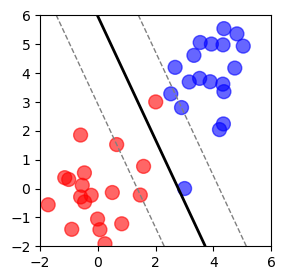

In [12]:
#| echo: false
#| fig-cap: The Decision Boundary Found by SMO SVM on Noisy Data

smo_svm = SMOSVM(C=0.2, tol=1e-3, max_iter=100)
smo_svm.fit(X_with_noise, y_with_noise)

# Plot the decision boundary
plt.figure(figsize=(3, 3))
plt.scatter(
    X_with_noise[:, 0], X_with_noise[:, 1], c=y_with_noise, cmap="bwr", alpha=0.6, s=100
)

show_hyperplane(smo_svm.decision_function)

plt.show()

### Hinge Loss With L2 Regularization

In addition to solving the dual problem, the soft margin SVM can also be addressed from another perspective: optimizing the regularized hinge loss. It can be shown that the original optimization problem of the soft margin SVM is equivalent to the following optimization problem:

$$
\min\limits_{\mathbf{w}, b} \quad \lambda||\mathbf{w}||^2 + \sum_{i=1}^{n}{\max(0, 1-y_i(\mathbf{w}\cdot\mathbf{x}_i+b))}
$$

Here, the first term is the regularization term, and $\lambda$ is the regularization parameter, which controls the trade-off between the two terms and is inversely proportional to $C$ above. When $\lambda$ approaches 0, the penalty from regularization decreases, and the model tends to classify the data correctly. When $\lambda=0$, the model essentially becomes the hard margin SVM.

In this case, if the dataset is linearly separable, the model can find a hyperplane that perfectly classifies the data, but it will be extremely sensitive to noise and outliers, leading to poor generalization. To balance perfect classification with generalization ability, $\lambda$ is usually set to a value greater than 0. In this way, while the model pursues perfect classification, it also minimizes the norm of the weights as much as possible, thereby enlarging the margin (recall that the margin is the inverse of $||\mathbf{w}||$), and improving generalization.

From the perspective of model complexity, regularization constrains the parameter space by eliminating large values of weights, thus limiting the number of hypotheses in the hypothesis set $\mathbb{H}$, reducing model complexity, and lowering the risk of overfitting. This reflects the idea of the bias-variance trade-off.

The second term is the hinge loss, which is named after its shape, as shown in the figure below. When the functional margin is greater than or equal to 1

$$
y_i(\mathbf{w}\cdot\mathbf{x}_i+b)\ge1
$$

it means the point lies outside the margin or exactly on it, so no penalty is applied. When the margin is less than 1, the penalty equals the distance by which the point falls short of the margin. The closer the point is to the hyperplane, the larger the violation of the margin, and thus the heavier the penalty.

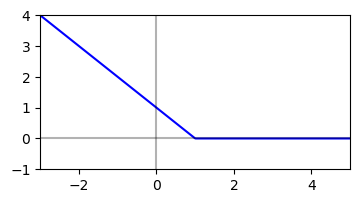

In [13]:
#| fig-cap: The Illustration of Hinge Loss
#| echo: false
plt.figure(figsize=(4, 2))
xvals = np.linspace(-10, 10, 1000)
yvals = np.maximum(0, 1 - xvals)
plt.plot(xvals, yvals, "b-")
plt.axhline(y=0, color="black", alpha=0.3)
plt.axvline(color="black", alpha=0.3)
plt.xlim(-3, 5)
plt.ylim(-1, 4)
plt.show()

The following code demonstrates how to compute hinge loss with L2 regularization in Python. First, the distance of each point to the hyperplane is calculated. Points with distance greater than 1 are set to 0, and then the average is taken to obtain the hinge loss. The regularization term is computed according to the formula, and finally the two terms are added together to obtain the final loss value.

```python
def loss(X, y, w, b, lambda_):
    distances = y * (X @ w + b)
    hinge_loss = np.mean(np.maximum(0, 1 - distances))
    reg_loss = lambda_ * (w @ w)
    return hinge_loss + reg_loss
```

### Mini-batch SGD

Since the hinge loss is almost everywhere differentiable and is a convex function, in addition to analytical methods, one can also use stochastic gradient descent (SGD) to find the minimum. SGD refers to updating the parameters in the direction determined by the gradient of the function. At non-differentiable points, a sub-gradient is chosen to replace the gradient. For example, for the hinge loss function, at non-differentiable points, any element from

$$
\{-\alpha y \mathbf{x} \mid \alpha \in [0, 1]\}
$$

can be chosen as the sub-gradient. Since the gradient always points in the direction of steepest ascent, its negative points to the steepest descent direction. Because the objective function is convex, descending along the steepest slope at each step will gradually lead us closer to the minimum of the function, i.e., the point where the hinge loss is minimized.

The stochastic nature of SGD comes from computing the gradient on a small randomly sampled batch of data from the dataset each time. This avoids the expensive computation cost of calculating gradients over the entire dataset, while also avoiding the instability of using just a single data point, thus achieving a balance.

#### Gradient Calculation

To compute the gradient of the hinge loss, first write hinge loss in a piecewise form:

$$
L_i(\mathbf{w}, b) = \left\{
  \begin{array}{lr}
    1 - y_i (\mathbf{w} \cdot \mathbf{x}_i + b) + \lambda ||\mathbf{w}||^2 & \text{if } 1 - y_i (\mathbf{w} \cdot \mathbf{x}_i + b) > 0 \\
    \lambda ||\mathbf{w}||^2 & \text{otherwise}
  \end{array}
\right.
$$

This function is non-differentiable at the piecewise boundary, but differentiable elsewhere. When $1-y_i(\mathbf{w}\cdot\mathbf{x}_i+b)>0$,

$$
\nabla_{\mathbf{w}}L_i(\mathbf{w}, b) = -y_i \mathbf{x}_i + 2 \lambda \mathbf{w}
$$

$$
\nabla_{b}L_i(\mathbf{w}, b) = -y_i
$$

When $1-y_i(\mathbf{w}\cdot\mathbf{x}_i+b) < 0$, the hinge loss is 0, and only the regularization term is considered:

$$
\nabla_{\mathbf{w}}L_i(\mathbf{w}, b) = 2 \lambda \mathbf{w}
$$

$$
\nabla_{b}L_i(\mathbf{w}, b) = 0
$$

The following code demonstrates how to compute the gradient. First, the distance of each point to the hyperplane is calculated. Then, depending on whether the distance is greater than 1, the gradient is computed differently. For points with distance less than 1, the gradient is the sum of the hinge loss gradient and the regularization term gradient. For points with distance greater than 1, the hinge loss gradient is 0, and only the regularization term gradient is computed. Here, for points with distance exactly equal to 1, the sub-gradient is chosen to be 0.

```python
def calc_gradient(X, y, w, b, lambda_):
    distances = y * (X @ w + b)
    mask = distances < 1
    dw = 2 * lambda_ * w
    if np.any(mask):
        dw += -np.mean((y[mask]).reshape(-1, 1) * X[mask], axis=0)
    db = 0.0
    if np.any(mask):
        db = -np.mean(y[mask])
    return dw, db
```

#### Learning Rate

The gradient determines the update direction at each step, while the learning rate controls the step size. If the learning rate is too large, the algorithm may overshoot the minimum, or even cause the loss to increase. If the learning rate is too small, convergence will be very slow, and in the case of non-convex optimization, it may increase the risk of getting stuck in a local optimum. Therefore, choosing an appropriate learning rate is also crucial. The two cases described above are illustrated in the figure below.

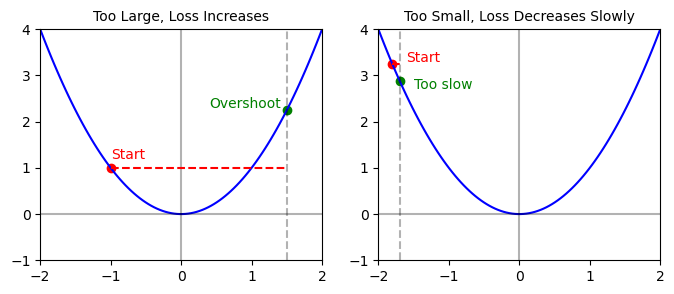

In [14]:
#| echo: false
#| fig-cap: Effects of Different Learning Rates on Convergence
def f(x):
    return np.array(x) ** 2


fig, axes = plt.subplots(1, 2, figsize=(8, 3))

x = np.linspace(-2, 2, 100)
y = f(x)
axes[0].plot(x, y, "b-")
axes[0].axhline(y=0, color="black", alpha=0.3)
axes[0].axvline(color="black", alpha=0.3)
axes[0].set_ylim(-1, 4)
axes[0].set_xlim(-2, 2)
axes[0].scatter([-1.0], f([-1.0]), color="red")
axes[0].plot([-1.0, 1.5], [f(-1), f(-1)], "r--")
axes[0].axvline(x=1.5, color="black", alpha=0.3, linestyle="--")
axes[0].scatter([1.5], f([1.5]), color="green")
axes[0].text(-1.0, 1.2, "Start", fontsize=10, color="red")
axes[0].text(0.4, 2.3, "Overshoot", fontsize=10, color="green")
axes[0].set_title("Too Large, Loss Increases", fontsize=10)

axes[1].plot(x, y, "b-")
axes[1].axhline(y=0, color="black", alpha=0.3)
axes[1].axvline(color="black", alpha=0.3)
axes[1].set_ylim(-1, 4)
axes[1].set_xlim(-2, 2)
axes[1].scatter([-1.8], f([-1.8]), color="red")
axes[1].plot([-1.8, -1.7], [f(-1.8), f(-1.8)], "r--")
axes[1].axvline(x=-1.7, color="black", alpha=0.3, linestyle="--")
axes[1].scatter([-1.7], f([-1.7]), color="green")
axes[1].text(-1.6, 3.3, "Start", fontsize=10, color="red")
axes[1].text(-1.5, 2.7, "Too slow", fontsize=10, color="green")
axes[1].set_title("Too Small, Loss Decreases Slowly", fontsize=10)
plt.show()

Apart from using a fixed learning rate, a dynamically adjusted learning rate can be used. For example, the learning rate can gradually decrease as the number of iterations increases. The advantage of this approach is that in the initial stage, a larger learning rate allows the algorithm to quickly approach the optimal solution; while in the later stage, a smaller learning rate helps avoid overshooting the optimum and allows more stable convergence.

#### Update Strategy

Having calculated the gradient and chosen a appropriate learning rate, the parameters can be updated as follows:

$$
\begin{aligned}
&\mathbf{w} \leftarrow \mathbf{w} - lr  \nabla_{\mathbf{w}}L_i(\mathbf{w}, b) \\
&b \leftarrow b - lr  \nabla_{b}L_i(\mathbf{w}, b)
\end{aligned}
$$

where $lr$ is the learning rate.

The complete learning process is as follows:

1. First, randomly initialize the model parameters $\mathbf{w}$ and $b$.
2. Then, in each iteration, split all the data into multiple mini-batches.
3. For each mini-batch, compute the gradient for that batch and update the model parameters.
4. Repeat steps 2 and 3 until the preset number of iterations is reached.

The code is shown below:

```python
w = np.random.normal(0, 0.01, n_features)
b = 0.0

for epoch in range(n_epochs):
    batches = get_batches(X, y, batch_size)
    for batch in batches:
        dw, db = gradient(X_batch, y_batch)
        w -= lr * dw
        b -= lr * db
```

In [15]:
#| echo: false
class SGDSVM:
    def __init__(self, lambda_=0.01, lr=0.01, epochs=10, batch_size=64):
        self.lambda_ = lambda_
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss_history = []

    def loss(self, X, y):
        distances = 1 - y * (X @ self.w + self.b)
        hinge_loss = np.maximum(0, distances).mean()
        reg = self.lambda_ * (self.w @ self.w)
        return hinge_loss + reg

    def gradient(self, X, y):

        # Decision values for batch
        distances = 1 - y * (X @ self.w + self.b)

        # Identify samples with hinge loss > 0
        mask = distances > 0

        # Gradient w.r.t w
        dw = 2 * self.lambda_ * self.w
        if np.any(mask):
            dw += -np.mean((y[mask]).reshape(-1, 1) * X[mask], axis=0)

        # Gradient w.r.t b
        db = 0.0
        if np.any(mask):
            db = -np.mean(y[mask])

        return dw, db

    def fit(self, X, y):
        np.random.seed(42)
        n_samples, n_features = X.shape
        self.w = np.random.normal(0, 0.01, n_features)
        self.b = 0.0

        self.losses_train = []

        for epoch in range(self.epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled, y_shuffled = X[indices], y[indices]

            for i in range(0, n_samples, self.batch_size):

                # numpy array never go out of index range with slicing
                X_batch = X_shuffled[i : i + self.batch_size]
                y_batch = y_shuffled[i : i + self.batch_size]

                dw, db = self.gradient(X_batch, y_batch)
                self.w -= self.lr * dw
                self.b -= self.lr * db

            self.loss_history.append(self.loss(X, y))

    def decision_function(self, X):
        return X @ self.w + self.b

    def predict(self, X):
        return np.sign(self.decision_function(X))

### Comparison With Hard Margin SVM

As shown in the figure below, after introducing two outliers into the original dataset, the decision boundary of the hard margin classifier is largely shifted due to the influence of the noise, producing a hyperplane with very narrow margins, whereas the soft margin classifier is less affected by outliers, because it allows some points to violate the margin or even be misclassified.

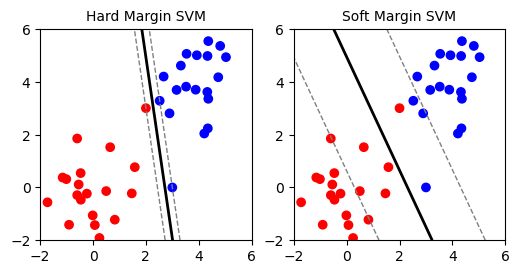

In [16]:
#| echo: false
#| fig-cap: Comparison Between Hard Margin SVM and Soft Margin SVM on Noisy Data
hard_svm = HardMarginSVM()
hard_svm.fit(X_with_noise, y_with_noise)
sgd_svm = SGDSVM(epochs=200, lr=0.01, lambda_=0.1)
sgd_svm.fit(X_with_noise, y_with_noise)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].scatter(
    X_with_noise[:, 0], X_with_noise[:, 1], c=y_with_noise, cmap="bwr", alpha=1
)
axes[0].set_title("Hard Margin SVM", fontsize=10)
axes[1].set_title("Soft Margin SVM", fontsize=10)
axes[1].scatter(
    X_with_noise[:, 0], X_with_noise[:, 1], c=y_with_noise, cmap="bwr", alpha=1
)
show_hyperplane(hard_svm.decision_function, ax=axes[0])
show_hyperplane(sgd_svm.decision_function, ax=axes[1])
plt.show()

The figure below shows different decision boundaries obtained by the soft margin SVM with different values of the regularization parameter $\lambda$. A smaller $\lambda$ (equivalent to a larger $C$) means a smaller penalty for misclassification, leading to a narrower margin and a more complex model that fits the training data better but may overfit. Conversely, a larger $\lambda$ (equivalent to a smaller $C$) results in a wider margin and a simpler model that may underfit the training data but generalizes better.

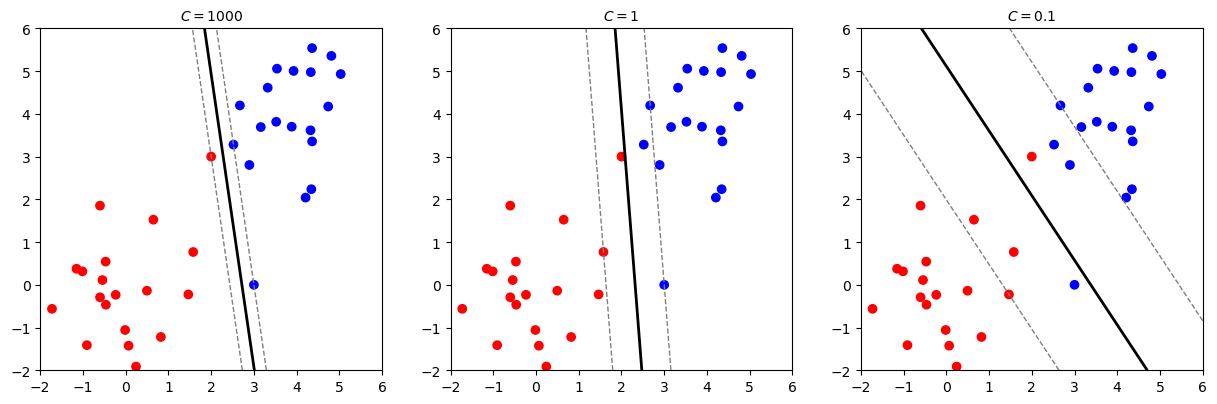

In [17]:
#| echo: false
#| fig-cap: Effect of Regularization Parameter on Decision Boundary of Soft Margin SVM
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
Cs = [1000, 1, 0.1]
titles = [r"$C=1000$", r"$C=1$", r"$C=0.1$"]
for ax, C, title in zip(axes, Cs, titles):
    smo_svm = SMOSVM(C, tol=1e-3, max_iter=100)
    smo_svm.fit(X_with_noise, y_with_noise)
    ax.set_title(title, fontsize=10)
    ax.scatter(
        X_with_noise[:, 0], X_with_noise[:, 1], c=y_with_noise, cmap="bwr", alpha=1
    )
    show_hyperplane(smo_svm.decision_function, ax=ax)
plt.show()

# Experiments On MNIST Dataset

## Dataset Description

The input dataset $X$ consists of $28\times28$ pixel grayscale images of handwritten digits. The pixel values range from 0 to 255 where 0 represents pure white and 255 represents pure black. The pixel values are normalized to the range $[0, 1]$ by dividing by 255. The training set contains 60,000 images and the test set contains 10,000 images. In this experiment, only the digits 3 and 7 are used to form a binary classification problem. Each image is flattened into a 784-dimensional vector. The output is a binary label indicating whether the digit is a 3 or a 7. 

In [18]:
#| echo: false

import idx2numpy

train_images = idx2numpy.convert_from_file("./mnist/archive/train-images.idx3-ubyte")
train_labels = idx2numpy.convert_from_file("./mnist/archive/train-labels.idx1-ubyte")
test_images = idx2numpy.convert_from_file("./mnist/archive/t10k-images.idx3-ubyte")
test_labels = idx2numpy.convert_from_file("./mnist/archive/t10k-labels.idx1-ubyte")
threes = train_images[train_labels == 3].reshape(-1, 28 * 28).astype(np.float32) / 255.0
sevens = train_images[train_labels == 7].reshape(-1, 28 * 28).astype(np.float32) / 255.0
fives = train_images[train_labels == 5].reshape(-1, 28 * 28).astype(np.float32) / 255.0
fives_valid = (
    test_images[test_labels == 5].reshape(-1, 28 * 28).astype(np.float32) / 255.0
)
threes_valid = (
    test_images[test_labels == 3].reshape(-1, 28 * 28).astype(np.float32) / 255.0
)
sevens_valid = (
    test_images[test_labels == 7].reshape(-1, 28 * 28).astype(np.float32) / 255.0
)

The figure below shows some samples of the digits 3 and 7 from the training set.

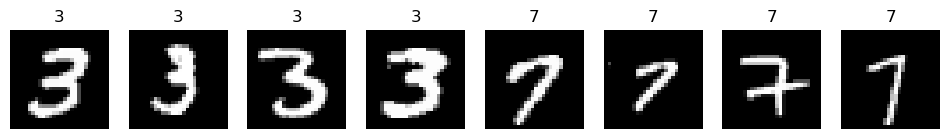

In [19]:
#| echo: false

X = np.vstack([threes, sevens])
y = np.array([1] * len(threes) + [-1] * len(sevens))
X_valid = np.vstack([threes_valid, sevens_valid])
y_valid = np.array([1] * len(threes_valid) + [-1] * len(sevens_valid))

show_images(
    [
        threes[0].reshape(28, 28),
        threes[1].reshape(28, 28),
        threes[2].reshape(28, 28),
        threes[3].reshape(28, 28),
        sevens[0].reshape(28, 28),
        sevens[1].reshape(28, 28),
        sevens[2].reshape(28, 28),
        sevens[3].reshape(28, 28),
    ],
    titles=["3", "3", "3", "3", "7", "7", "7", "7"],
)

## Training with SGD SVM

The code below trains a soft margin SGD based SVM.  

In [20]:
sgd_svm = SGDSVM(epochs=200, lr=0.0001, lambda_=0.001)
sgd_svm.fit(X, y)

The figure below shows the training loss curve. It can be seen that the loss decreases rapidly in the initial stage and then gradually stabilizes.

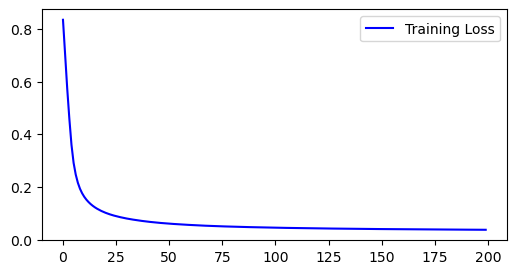

In [21]:
#| echo: false
#| fig-cap: Training Loss Curve of SGD SVM on MNIST
plt.figure(figsize=(6, 3))
plt.plot(sgd_svm.loss_history, color="blue", label="Training Loss")

plt.legend()
plt.show()

The code below calculates the accuracy on the validation set.

In [22]:
print(
    f"The accuracy on the validation set is: {(sgd_svm.predict(X_valid) == y_valid).mean()*100:.2f}%"
)

The accuracy on the validation set is: 98.28%


The figure below visualizes the learned weights. The red areas indicate positive weights, while the blue areas indicate negative weights. It can be observed that the model focuses on the regions that are most discriminative between the digits 3 and 7.

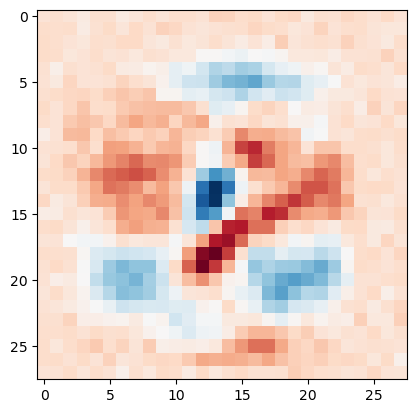

In [23]:
#| echo: false
#| fig-cap: Visualization of Learned Weights by SGD SVM
plt.imshow(sgd_svm.w.reshape(28, 28), cmap="RdBu", aspect="equal")

The figure below shows the confusion matrix of the predictions on the validation set. It can be seen that most samples are correctly classified, with only a few misclassifications.

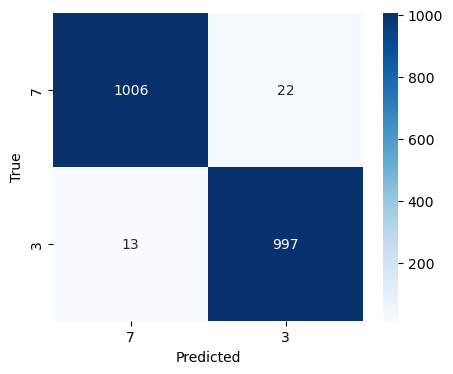

In [24]:
#| echo: false
#| fig-cap: Confusion Matrix and Classification Report of SGD SVM on MNIST
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

y_pred = sgd_svm.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["7", "3"],
    yticklabels=["7", "3"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The table below shows the precision, recall, and F1-score for each class.

In [25]:
print(classification_report(y_valid, y_pred, target_names=["7", "3"]))

              precision    recall  f1-score   support

           7       0.99      0.98      0.98      1028
           3       0.98      0.99      0.98      1010

    accuracy                           0.98      2038
   macro avg       0.98      0.98      0.98      2038
weighted avg       0.98      0.98      0.98      2038



## Comparison with SMO Algorithm

SMO algorithm is expected to be able to find a more accurate solution to the soft margin SVM problem because it directly solves the dual problem. The code below randomly selects 500 samples from the training set to form a smaller training set and trains an SMO SVM on it.

In [26]:
n_train_samples = 500
indices = np.random.choice(len(X), n_train_samples, replace=False)
X_train_small = X[indices]
y_train_small = y[indices]

smo_mnist = SMOSVM(C=100, tol=1e-3, max_iter=50)
smo_mnist.fit(X_train_small, y_train_small)

The code below evaluates the SMO SVM on the validation set and compares it with the SGD SVM trained on the same small subset. SMO SVM and SGD SVM have almost the same performance.

In [27]:
#| echo: false
# Evaluate SMO SVM on validation set
y_pred_smo = smo_mnist.predict(X_valid)
accuracy_smo = accuracy_score(y_valid, y_pred_smo)
print(f"SMO SVM accuracy on validation set: {accuracy_smo*100:.2f}%")

sgd_svm_small = SGDSVM(epochs=1000, lr=0.0001, lambda_=0.001)
sgd_svm_small.fit(X_train_small, y_train_small)
y_pred_sgd_small = sgd_svm_small.predict(X_valid)
accuracy_sgd_small = accuracy_score(y_valid, y_pred_sgd_small)
print(f"SGD SVM accuracy on validation set: {accuracy_sgd_small*100:.2f}%")

SMO SVM accuracy on validation set: 97.20%
SGD SVM accuracy on validation set: 97.25%


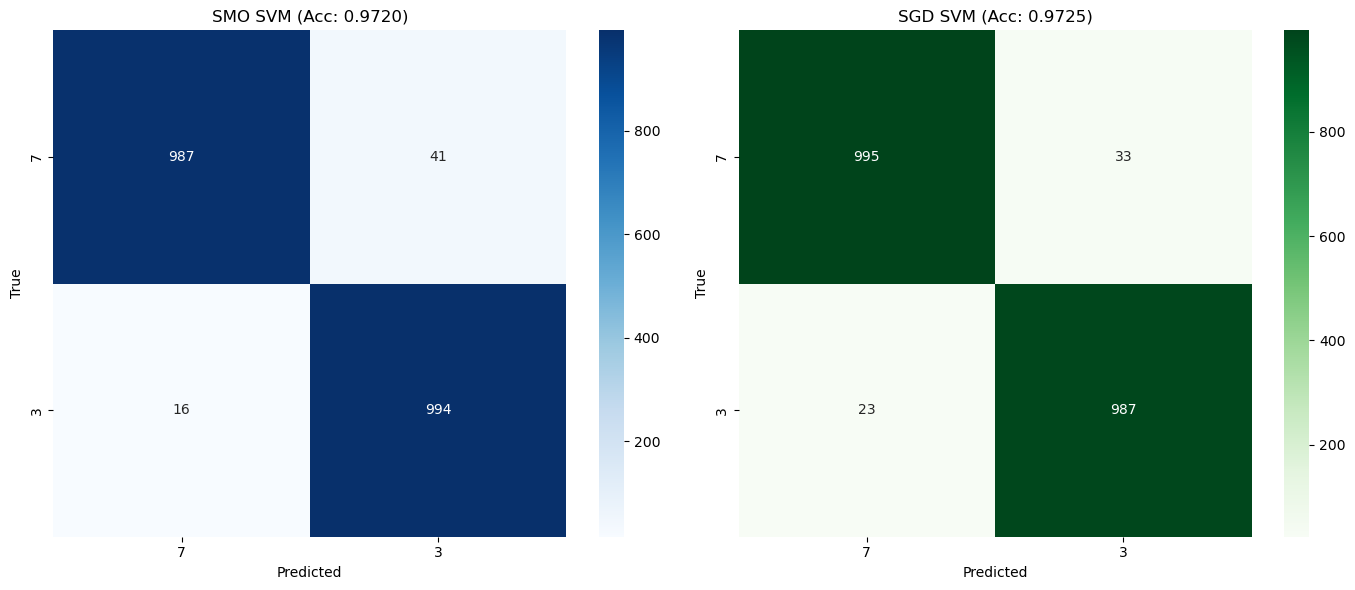

In [28]:
#| echo: false
#| fig-cap: Confusion Matrices of SMO SVM and SGD SVM on MNIST Validation Set
cm_smo = confusion_matrix(y_valid, y_pred_smo)
cm_sgd = confusion_matrix(y_valid, y_pred_sgd_small)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(
    cm_smo,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["7", "3"],
    yticklabels=["7", "3"],
    ax=axes[0],
)
axes[0].set_title(f"SMO SVM (Acc: {accuracy_smo:.4f})")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(
    cm_sgd,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["7", "3"],
    yticklabels=["7", "3"],
    ax=axes[1],
)
axes[1].set_title(f"SGD SVM (Acc: {accuracy_sgd_small:.4f})")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

In conclusion, the comparison shows that both SMO and SGD based approaches can effectively solve the soft margin SVM problem.

# Multi-class SVM

SVM is not able to handle multi-class classification problems directly due to its binary nature. However, there are two common strategies to extend SVM to multi-class problems: one-versus-the-rest (OvR) and one-versus-one (OvO), both of which involve training multiple binary classifiers.

## One Versus The Rest

One versus rest (OvR) refers to training $k$ binary classifiers for a $k$-class classification problem. Each classifier is trained to distinguish one class from all other classes. During training, the $k$th classifier is trained using the samples from the $k$th class as positive examples and samples from all other classes as negative examples. During prediction, the classifier that outputs the highest decision function value determines the predicted class. One disadvantage of this approach is that one data point may be classified into multiple classes. Another disadvantage is that the classifiers are very likely to be imbalanced, as the positive data from one class while the negative data from all other classes. 

## One Versus One

One versus one (OvO) refers to training $\binom{k}{2}$ binary classifiers for a $k$-class classification problem. Each classifier is trained to distinguish between a pair of classes. The advantage of this approach is that each classifier is trained on a balanced dataset, as each classifier only uses data from two classes. During prediction, each classifier votes for one of the two classes it was trained on, and the class with the most votes is chosen as the final prediction. One disadvantage of this approach is that it requires training a large number of classifiers, which can be computationally expensive for problems with many classes. Another disadvantage is that the classifiers may be inconsistent, as different classifiers may produce conflicting predictions.

@bishop_pattern_2006 lists several methods for addressing aforementioned issues like Direct Acyclic Graph SVM (DAGSVM) and concludes that in practice, OvR is widely used. Therefore, in this section, I will implement the OvR strategy using the SGD SVM and test it on a three-class classification problem using digits 3, 5, and 7 from the MNIST dataset.

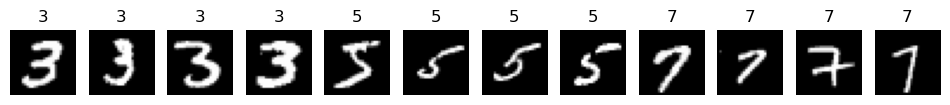

In [29]:
#| echo: false
#| fig-cap: Some Samples of Digits 3, 5, and 7 from the MNIST Dataset
X = np.vstack([threes, fives, sevens])
y = np.array([0] * len(threes) + [1] * len(fives) + [2] * len(sevens))
X_valid = np.vstack([threes_valid, fives_valid, sevens_valid])
y_valid = np.array(
    [0] * len(threes_valid) + [1] * len(fives_valid) + [2] * len(sevens_valid)
)

show_images(
    [
        threes[0].reshape(28, 28),
        threes[1].reshape(28, 28),
        threes[2].reshape(28, 28),
        threes[3].reshape(28, 28),
        fives[0].reshape(28, 28),
        fives[1].reshape(28, 28),
        fives[2].reshape(28, 28),
        fives[3].reshape(28, 28),
        sevens[0].reshape(28, 28),
        sevens[1].reshape(28, 28),
        sevens[2].reshape(28, 28),
        sevens[3].reshape(28, 28),
    ],
    titles=["3", "3", "3", "3", "5", "5", "5", "5", "7", "7", "7", "7"],
)

The code below implements the OvR strategy using the previously defined `SGDSVM` class. The `OvR_SGD_SVM` class contains a list of `SGDSVM` models, one for each class. During training, each model is trained to distinguish one class from all other classes. During prediction, the model that outputs the highest decision function value determines the predicted class.

In [30]:
class OvR_SGD_SVM:
    def __init__(self, n_classes, lambda_=0.01, lr=0.01, epochs=10, batch_size=64):
        self.n_classes = n_classes
        self.models = [
            SGDSVM(lambda_=lambda_, lr=lr, epochs=epochs, batch_size=batch_size)
            for _ in range(n_classes)
        ]

    def fit(self, X, y):
        for i in range(self.n_classes):
            y_binary = np.where(y == i, 1, -1)
            self.models[i].fit(X, y_binary)

    def predict(self, X):
        decision_values = np.array([model.predict(X) for model in self.models])
        return np.argmax(decision_values, axis=0)

The code below trains the OvR SGD SVM on the three-class dataset and evaluates it on the validation set in terms of accuracy.

In [31]:
ovr_svm = OvR_SGD_SVM(n_classes=3, epochs=200, lr=0.0001, lambda_=0.001)
ovr_svm.fit(X, y)
ovr_svm_pred = ovr_svm.predict(X_valid)
print(f"The accuracy on validation set is {(ovr_svm_pred == y_valid).mean()*100:.2f}%")

The accuracy on validation set is 94.81%


The figure below shows the confusion matrix of the predictions on the validation set. It can be seen that the model often confuses the digits 3 and 5, while the digit 7 is less likely to be misclassified. This makes sense because the digits 3 and 5 look more similar to each other compared to the digit 7.

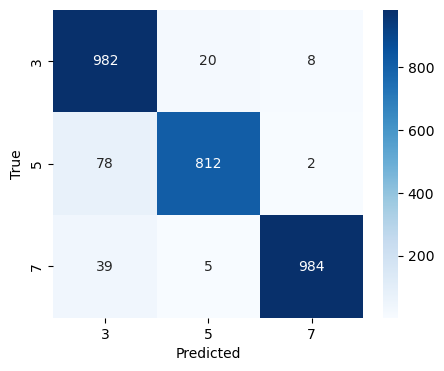

In [32]:
#| echo: false
#| fig-cap: Confusion Matrix of OvR SGD SVM on MNIST Validation Set
cm = confusion_matrix(y_valid, ovr_svm_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["3", "5", "7"],
    yticklabels=["3", "5", "7"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Reflection and Conclusion

The motivation for me choosing the SVM as the topic of this report is that unlike other gradient based models that highly rely on numerical optimization and experience in tuning hyperparameters, SVM has a solid theoretical foundation and can be solved analytically. This makes it a little bit harder to understand than other models, but also more interesting. It intimidated me in the first semester when I learned it in the fundamental data analytics course. The concepts and terminologies from optimization theory like convex optimization, lagrange duality, and so forth stopped me from going through the underlying principles of SVM. Therefore, I decided to take a deep dive into SVM in this report.

Along the way, I learned basic knowledge about convex optimization and reviewed some rusty concepts from linear algebra. The biggest challenge for me is to understand the mathematical derivations from the primal problem to the dual problem, because it involves a lot of summation operations. Another challenge is to derive and implement the SMO algorithm, which also involves a lot of calculations, and the implementation of SMO requires handling many details, such as dealing with edge cases. In this process, @bishop_pattern_2006, @platt_sequential_1998 and @james_support_2023 are very helpful to me. The conclusions and inferences used in this report are mainly based on these references. AI is also employed to answer some specific questions, assist in writing some code and translation. The link of the conversation with AI can be found in appendix.

The limitation of this report is that it only covers the linear SVM, while in practice, kernel SVM is commonly used. It is also worth mentioning that the implementation of SMO in this report is not optimized for efficiency. During training, it takes forever to converge on the whole MNIST dataset. In practice, libraries like LIBSVM and scikit-learn have highly optimized implementations of SVM that can handle large datasets efficiently.

In conclusion, this report provides a comprehensive overview of the principles and implementation of SVM. It covers both hard margin and soft margin SVM, as well as multi-class classification using the OvR strategy. Through theoretical analysis and practical experiments, it demonstrates the effectiveness of SVM in handling classification tasks.

# References

::: {#refs}

:::

# Appendix

1. The conversation with AI can be found at [here](https://chatgpt.com/share/68e5ef22-459c-8000-b1cb-820eedb221cb) and [here](https://chatgpt.com/share/68e5f170-603c-8000-9bc4-a915d61c59e1).
2. The jupyter notebook for the visualizations and the implementations of the models in this report can be found at [here](https://colab.research.google.com/drive/1OjK9RxJK0tJ5NS8ND3SRkLxcXDtOuQCi?usp=sharing).
3. This report is written in Quarto markdown. The source code of this report can be found at [here](https://github.com/chenkeao/A-Study-On-SVMs).
4. This report uses `quarto titlepages` theme, which can be found [here](https://nmfs-opensci.github.io/quarto_titlepages/).
5. The picture on the cover page is from [here](https://blog.pluskid.org/archives/632).
